In [1]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mplcursors
import ipywidgets as widgets

import h5py 
import os,sys,glob
import pandas as pd
import ipympl

from matplotlib.widgets import Button
from IPython.display import  display

In [2]:
visitpath = '/dls/staging/dls/k11/data/2024/mg34950-1'
imgfileno = 38030
diffileno = 38031

In [3]:
dfile=glob.glob(visitpath + '/processed/k11-' + str(diffileno) + '-diffraction*.nxs')
with h5py.File(dfile[0],'r') as f:
    data=f['processed/result/data'][()]
    qvals=f['processed/result/q'][()]
    kbx = f['entry/diffraction/kb_cs_x'][()]
    kby = f['entry/diffraction/kb_cs_y'][()]
    theta=round(f['entry/diffraction_sum/gts_theta'][()].max(),2)

ifile=glob.glob(visitpath + '/processed/Savu_k11-' + str(imgfileno) + '*/k11-' + str(imgfileno) + '_processed.nxs')
with h5py.File(ifile[0],'r') as f:
    indx = np.where(np.abs(f['entry/input_data/tomo/rotation_angle'][()] - theta) <= 0.05)[0][0]
    proj=f['entry/intermediate/1-DarkFlatFieldCorrection-tomo/data'][indx,:,:]

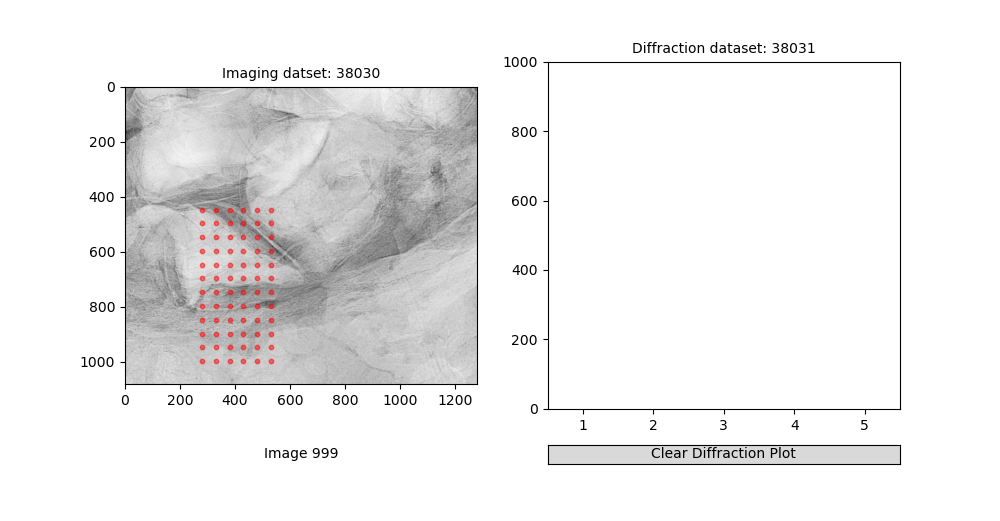

In [4]:
# Calculate the aspect ratio for the first subplot based on its limits
x_range = len(proj[0])  # from xlim(0, 1280)
y_range = len(proj)  # from ylim(1080, 0)
aspect_ratio = y_range / x_range

# Create a single figure with space for controls and subplots
fig_width = 10  # total figure width
subplot_width = fig_width / 2  # each subplot gets approximately half the width
fig_height = subplot_width * aspect_ratio + 1  # add extra height for controls

fig = plt.figure(figsize=(fig_width, fig_height))

# Create a gridspec with space for controls and plots
gs = fig.add_gridspec(2, 2, height_ratios=[0.95, 0.05], width_ratios=[1, 1])

# Create subplot axes
ax1 = fig.add_subplot(gs[0, 0])  # First subplot
ax2 = fig.add_subplot(gs[0, 1])  # Second subplot

# First subplot settings
ax1.set_xlim(0, x_range)
ax1.set_ylim(y_range, 0)
ax1.set_title('Imaging datset: ' + str(imgfileno), fontsize=10)
ax1.imshow(proj, cmap='Greys', aspect='equal')  # Force aspect ratio to be equal

# Second subplot settings
ax2.set_xlim(0.5, 5.5)
ax2.set_ylim(0, 1000)
ax2.set_title('Diffraction dataset: ' + str(diffileno), fontsize=10)

temp = []
scatter_plots = []
xrd = []

def plot_scatter(kbx, kby):
    for i in range(len(kbx)):
        for j in range(len(kby)):
            temp.append([kbx[i], kby[j], np.sum(data[j,i,2600:2800])])
            sc = ax1.scatter(kbx[i], kby[j], c='r', s=10, alpha=0.5)
            scatter_plots.append(sc)

combinedsc = [sc for sc in scatter_plots]
plot_scatter(kbx, kby)

#scale = 0.05  # this is arbitrary at the moment
#cor = len(kby)/len(kbx)
#kbx_0, kbx_1 = kbx.min()*(1-scale*cor), kbx.max()*(1+scale)
#kby_0, kby_1 = kby.min()*(1-scale), kby.max()*(1+scale/cor)
#xlen = kbx_1 - kbx_0
#ylen = kby_1 - kby_0
#offset = (kbx_1-kbx_0)/len(kbx)/2

def plotxrd(df):
    c = 0
    for no, row in df.iterrows():
        ax2.plot(qvals, row['y']+c, 'k')
        c += 10
        fig.canvas.draw_idle()

def clear_plot(event):
    # Only clear the second figure (diffraction plot)
    ax2.clear()
    xrd.clear()
    
    # Reset the axes limits and title for the second plot
    ax2.set_xlim(0.5, 5.5)
    ax2.set_ylim(0, 1000)
    
    fig.canvas.draw_idle()

def on_click(sel):
    sel.artist.set_facecolor('blue')
    x = np.where(kbx==sel.target[0])[0][0]
    y = np.where(kby==sel.target[1])[0][0]
    xrd.append([sel.target[0], sel.target[1], data[y,x,:]])
    xrd_df = pd.DataFrame(xrd, columns=['kbx', 'kby', 'y'])
    xrd_df = xrd_df.drop_duplicates(subset=['kbx', 'kby'])
    plotxrd(xrd_df)

cursor = mplcursors.cursor(combinedsc, hover=False)
cursor.connect("add", lambda sel: on_click(sel))

# Event handler for clicking on a point
#def on_click(event):
#    print('clicked')
#    if event.inaxes == ax:
#        click_x = event.xdata
#        click_y = event.ydata
#        
#        # Find the nearest point (if any point is within a threshold distance)
#        distances = np.sqrt((x - click_x)**2 + (y - click_y)**2)
#        threshold = 0.05  # Adjust this threshold as needed
#        nearest_index = np.argmin(distances)
#        
#        if distances[nearest_index] < threshold:
#            stack_new_plot(None)
#
# Connect the event handler
#fig.canvas.mpl_connect('button_press_event', on_click)

# Create button axis in the top left
clear_ax = fig.add_subplot(gs[1, 1])
clear_button = Button(clear_ax, 'Clear Diffraction Plot')  # Updated button text
clear_button.on_clicked(clear_plot)

# Hide the top right axis (reserved for potential future controls)
fig.add_subplot(gs[1, 1]).set_visible(False)

# Adjust the layout
#plt.tight_layout()

text_ax = fig.add_subplot(gs[1, 0])
text_ax.text(0.5, 0.5, 'Image ' + str(indx), fontsize=10, ha='center', va='center')
text_ax.axis('off')

plt.show()